Modelling on sectors

In [ ]:
%config Completer.use_jedi = False

In [ ]:
pwd

In [ ]:
% cd ../../..

In [2]:
import warnings
import pythonia.lib.uri
from pythonia.lib.aws_auth import setup_refreshing_session
from pythonia.forecasting.science.scalers import RobustScalerWithCompression
from pythonia.forecasting.derived_confidence import single_company_confidence_on_raw

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn.metrics
from sklearn import linear_model, neighbors, ensemble, tree, svm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sklearn_pandas
from functools import reduce
from scipy.stats import ttest_ind
from itertools import product
import time

pd.options.display.max_rows = 1000
%matplotlib inline
warnings.simplefilter('ignore')
sns.set_style("white")

In [4]:
def evaluate(df, col_true='co_log_returns_true', col_pred='co_log_returns_pred', 
             col_pred_prob='co_log_returns_pred_prob', returns_median=0, returns_std=0, low_tolerance=0, 
            THR_long=.75, THR_short=.65):    
    df_clean = df[['quarter', col_true, col_pred, col_pred_prob]].replace([0, -np.inf, np.inf], np.nan).dropna()
    df_clean = df_clean[df_clean[col_true].abs() >= low_tolerance]
    
    df_clean = df_clean[((df_clean[col_pred] > 0) & (df_clean[col_pred_prob] > THR_long)) |
                        ((df_clean[col_pred] < 0) & (df_clean[col_pred_prob] > THR_short)) ]
    
    def mcc(xx):
        return sklearn.metrics.matthews_corrcoef(xx[col_true] > 0, xx[col_pred] > 0)

    def acc(xx):
        return sklearn.metrics.accuracy_score(xx[col_true] > 0, xx[col_pred] > 0)

    def weighted_returns(xx):
        xx_no_outliers = xx[(xx[col_true] - returns_median).abs() < 3 * returns_std]
        return (xx_no_outliers[col_true] * np.sign(xx_no_outliers[col_pred])).mean()
    
    def weighted_returns_std(xx):
        xx_no_outliers = xx[(xx[col_true] - returns_median).abs() < 3 * returns_std]
        return (xx_no_outliers[col_true] * np.sign(xx_no_outliers[col_pred])).std()
    
    def market_direction(xx):
        return (xx[col_true] > 0).mean()
    
    # include another condition for the longs 
    df_clean_long = df_clean.query(col_pred + ' > 0')
    df_clean_short = df_clean.query(col_pred + ' < 0')
    
    output = df_clean.groupby('quarter').agg(acc)[[col_true]].rename(columns={col_true:'acc'})
    output = output.join(df_clean_long.groupby('quarter').agg(acc)[[col_true]].rename(columns={col_true:'up_acc'}))
    output = output.join(df_clean_short.groupby('quarter').agg(acc)[[col_true]].rename(columns={col_true:'down_acc'}))
    output['equal_acc'] = (output['up_acc'] + output['down_acc']) / 2
    output = output.join(df_clean.groupby('quarter').agg(market_direction)[[col_true]].rename(columns={col_true:'mkt_direction'}))
    output = output.join(df_clean.groupby('quarter').agg(mcc)[[col_true]].rename(columns={col_true:'mcc'}))
    output = output.join(df_clean_long.groupby('quarter').count()[[col_true]].rename(columns={col_true:'up_count'}))
    output = output.join(df_clean_short.groupby('quarter').count()[[col_true]].rename(columns={col_true:'down_count'}))
    output = output.join(df_clean.groupby('quarter').agg(weighted_returns)[[col_true]].rename(columns={col_true:'weighted_returns'}))
    output = output.join(df_clean_long.groupby('quarter').agg(weighted_returns)[[col_true]].rename(columns={col_true:'up_returns'}))
    output = output.join(df_clean_short.groupby('quarter').agg(weighted_returns)[[col_true]].rename(columns={col_true:'down_returns'}))
    output['equal_returns'] = (output['up_returns'] + output['down_returns']) / 2
    output = output.join(df_clean.groupby('quarter').agg(weighted_returns_std)[[col_true]].rename(columns={col_true:'weighted_returns_std'}))
    
    return output

In [5]:
def scale_confidence_values(df, upper, lower):
    confidence_col = 'derived_confidence'
    df = df.dropna(subset=[confidence_col]).copy()
    # A lookback of 1 year is based on having enough data points to get a meaningful
    # distribution without having the problems they had seen in previous confidence models
    lookback = pd.Timedelta(days=365)
    lookback_date = lower - lookback
    df_train = df.query("@lookback_date < exit_date <= @lower")
    df_test = df.query("@lower < exit_date <= @upper")
    assert df_train.index.intersection(df_test.index).empty, "Train test values are intersecting"
    if len(df_train) < 1:
        return df_test

    qt = sklearn.preprocessing.QuantileTransformer(n_quantiles=10, random_state=0)
    qt.fit(df_train[[confidence_col]])
    df_test = df_test.assign(co_log_returns_pred_prob=qt.transform(df_test[[confidence_col]]))

    return df_test

In [6]:
LOOKBACK = pd.date_range(start='2009-12-31', end='2013-03-31', freq='Q')
CUTOFF_DATES_L = pd.date_range(start='2012-12-31', end='2018-03-31', freq='Q')
CUTOFF_DATES_U = pd.date_range(start='2014-03-31', end='2018-06-30', freq='Q')

In [7]:
def predict_returns_reg(df, FEATURES):
    '''
    FEATURES: list of strings
    '''
    TARGET = 'co_log_returns_true'
    df = df.replace([np.inf, -np.inf], np.nan)
    df[FEATURES] = df[FEATURES].fillna(0)
    
    LOOKBACK = pd.date_range(start='2009-12-31', end='2014-03-31', freq='Q')
    CUTOFF_DATES_L = pd.date_range(start='2013-12-31', end='2018-03-31', freq='Q')
    CUTOFF_DATES_U = pd.date_range(start='2014-03-31', end='2018-06-30', freq='Q')
    assert len(LOOKBACK) == len(CUTOFF_DATES_L) == len(CUTOFF_DATES_U), 'LOOKBACK, CUTOFF_DATES_L and CUTOFF_DATES_U are not equal'

    assert pd.Timestamp('now').floor('D') <= pd.Timestamp('2018-06-30'), \
        'Forecasting is only configured to run upto 2018-06-30'
    df_model_walking = pd.DataFrame()
    df_model_walking_with_conf = pd.DataFrame()

    for upper, lower, lookback in zip(CUTOFF_DATES_U, CUTOFF_DATES_L, LOOKBACK):

        df_train = df.query("@lookback < exit_date <= @lower")[[TARGET, 'exit_date'] + FEATURES].dropna(subset=[TARGET])
        df_train = df_train[df_train[TARGET] != 0]
        df_test = df.query("@lower < exit_date <= @upper")[[TARGET, 'exit_date'] + FEATURES]
        assert df_train.index.intersection(df_test.index).empty, "Train test values are intersecting"
        
 
        est = sklearn.pipeline.Pipeline([
            ('dfmapper', sklearn_pandas.DataFrameMapper([(FEATURES, None)])),
            ('scalar', RobustScalerWithCompression(alpha=1.0)),
            ('estimator', linear_model.BayesianRidge(fit_intercept=False))
        ])

        est.fit(df_train[FEATURES], df_train[TARGET])

        df_test = df_test.assign(
            co_log_returns_pred=est.predict(df_test[FEATURES]),
            co_log_returns_pred_prob=np.NAN,
        )
        df_model_walking = df_model_walking.append(df_test)
        

    df_dc = df_model_walking.sort_index().rename(columns={'co_log_returns_true': 'true', 'co_log_returns_pred': 'pred'})[['true', 'pred']]
    df_dc = df_dc.groupby('df_company_id').apply(single_company_confidence_on_raw)
    df_model_walking = df_model_walking.join(df_dc['derived_confidence'])

    # We do two loops to prevent
    for upper, lower in zip(CUTOFF_DATES_U, CUTOFF_DATES_L):
        df_model_walking_with_conf = df_model_walking_with_conf.append(scale_confidence_values(df_model_walking, upper, lower))

    pct_null = len(df_model_walking_with_conf[df_model_walking_with_conf['co_log_returns_pred_prob'].isnull()]) / len(df_model_walking_with_conf)

    assert pct_null < 0.01, "More that 1% of predictions have no confidence score"

    return df_model_walking_with_conf[['co_log_returns_pred', 'co_log_returns_pred_prob']]

In [8]:
def compute_metrics(output, start, stop):

    mcc_mean = output[start:stop].mcc.mean()
    mcc_std = output[start:stop].mcc.std()
    mcc_low_ci = mcc_mean - 1.96 * mcc_std

    equal_acc_mean = output[start:stop].equal_acc.mean()
    equal_acc_std = output[start:stop].equal_acc.std()
    equal_acc_low_ci = equal_acc_mean - 1.96 * equal_acc_std

    equal_returns_mean = output[start:stop].equal_returns.mean()
    equal_returns_std = output[start:stop].equal_returns.std()
    equal_returns_low_ci = equal_returns_mean - 1.96 * equal_returns_std
    
    support = output[start:stop][['up_count', 'down_count']].sum(axis=1).mean()
    
    mkt_direction_mean = output[start:stop].mkt_direction.mean()

    metrics = pd.Series({
        'mcc_low_ci': mcc_low_ci,
        'equal_acc_low_ci': equal_acc_low_ci,
        'equal_returns_low_ci': equal_returns_low_ci,
        'mean_support': support,
        'equal_acc_mean': equal_acc_mean,
        'mkt_direction_mean': mkt_direction_mean,
        
    })


    return metrics.T[['mcc_low_ci', 'equal_acc_low_ci', 'equal_returns_low_ci', 'mean_support',
                      'equal_acc_mean', 'mkt_direction_mean']]

In [9]:
def select_economic_sector(economic_sector: str):
    cid = info[info.economic_sector == economic_sector]['df_company_id'].unique()
    e_sector = df[df.index.get_level_values(0).isin(cid)]
    return e_sector


def select_business_sector(business_sector: str):
    cid = info[info.business_sector == business_sector]['df_company_id'].unique()
    b_sector = df[df.index.get_level_values(0).isin(cid)]
    return b_sector 

In [10]:
def run(df, feature_list, experiment_name):
    print('Experiment Name: %s' %experiment_name + '\nRunning an experiment on %d companies for:'%len(df.index.get_level_values(0).unique())
      + '\n%s' %feature_list) 
    sp_predictions = predict_returns_reg(df, FEATURES=feature_list).sort_index()
    predictions = df.merge(sp_predictions, left_index=True, right_index=True, how='left')
    experiment_results[experiment_name] = evaluate(predictions, returns_median=returns_median, returns_std=returns_std)

In [11]:
setup_refreshing_session('df_datascience_research_nonprod')

In [12]:
uri = 'dfc://forecasting/2018-04-27T12-15_ICaIQ'
collection = pythonia.lib.uri.Collection.from_uri(uri)

data = collection.get('forecasting/predictions').df.copy()
info = collection.get('input-data/company_info').df.copy()

df = data.drop(['co_log_returns_pred', 'co_log_returns_pred_prob'], axis=1)\
     .set_index(['df_company_id', 'event_index']).sort_index()
df['quarter'] = pd.PeriodIndex(df.exit_date, freq='Q')

In [13]:
returns_median = 0.005
returns_std = 0.05
experiment_results = {}

### EPS All Companies

In [15]:
features_vanilla = [
    'normalised_smart_eps_surprise_pred', 
    'normalised_smart_sal_surprise_pred',
    'consensus_eps_surprise_smart', 
    'consensus_sal_surprise_smart',
]

In [16]:
run(df, feature_list=features_vanilla, experiment_name='eps_all_companies')

Experiment Name: eps_all_companies
Running an experiment on 2044 companies for:
['normalised_smart_eps_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_eps_surprise_smart', 'consensus_sal_surprise_smart']


### Industrials EPS

In [17]:
df_industrials = select_economic_sector(economic_sector='Industrials')

In [18]:
len(df_industrials.index.get_level_values(0).unique())

303

In [19]:
run(df_industrials, feature_list=features_vanilla, experiment_name='eps_industrials')

Experiment Name: eps_industrials
Running an experiment on 303 companies for:
['normalised_smart_eps_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_eps_surprise_smart', 'consensus_sal_surprise_smart']


### Minerals Mining EPS

In [20]:
df_minerals = select_business_sector(business_sector='Mineral Resources')

In [21]:
run(df_minerals, feature_list=features_vanilla, experiment_name='eps_minerals')

Experiment Name: eps_minerals
Running an experiment on 44 companies for:
['normalised_smart_eps_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_eps_surprise_smart', 'consensus_sal_surprise_smart']


# EBITDA All Companies

In [22]:
features_ebitda = [
    'consensus_ebt_surprise_pred', 
    'normalised_smart_sal_surprise_pred', 
    'consensus_sal_surprise_smart'
]

In [23]:
run(df, feature_list=features_ebitda, experiment_name='ebitda_All')

Experiment Name: ebitda_All
Running an experiment on 2044 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


### Industrials EBITDA

In [24]:
df_industrials = select_economic_sector(economic_sector='Industrials')

In [25]:
run(df_industrials, feature_list=features_ebitda, experiment_name='ebitda_industrials')

Experiment Name: ebitda_industrials
Running an experiment on 303 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


### Mineral Resources EBITDA

In [26]:
run(df_minerals, feature_list=features_ebitda, experiment_name='ebitda_minerals')

Experiment Name: ebitda_minerals
Running an experiment on 44 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


### EBITDA Industrials without Commercial Services

In [27]:
cid = info[(info.economic_sector == 'Industrials') & 
     (info.business_sector != 'Industrial & Commercial Services')]['df_company_id'].unique()

df_industrials_no_commercial = df[df.index.get_level_values(0).isin(cid)]

In [28]:
run(df_industrials_no_commercial, feature_list=features_ebitda, experiment_name='ebitda_industrials_no_commercial')

Experiment Name: ebitda_industrials_no_commercial
Running an experiment on 195 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


# EBITDA All Except Financials

In [30]:
cid = info[(info.economic_sector != 'Financials')]['df_company_id'].unique()

non_financials = df[df.index.get_level_values(0).isin(cid)]
run(non_financials, feature_list=features_ebitda, experiment_name='ebitda_no_financials')

Experiment Name: ebitda_no_financials
Running an experiment on 1566 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


In [31]:
# we lose 478 companies after taking out financials

# EPS All Except Financials

In [32]:
cid = info[(info.economic_sector != 'Financials')]['df_company_id'].unique()
non_financials = df[df.index.get_level_values(0).isin(cid)]
run(non_financials, feature_list=features_vanilla, experiment_name='eps_no_financials')

Experiment Name: eps_no_financials
Running an experiment on 1566 companies for:
['normalised_smart_eps_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_eps_surprise_smart', 'consensus_sal_surprise_smart']


# EBITDA Basic Materials

In [35]:
cid = info[(info.economic_sector == 'Basic Materials')]['df_company_id'].unique()

In [36]:
ebitda_basic_materials = df[df.index.get_level_values(0).isin(cid)]
run(ebitda_basic_materials, feature_list=features_ebitda, experiment_name='ebitda_basic_materials')

Experiment Name: ebitda_basic_materials
Running an experiment on 117 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


# Consumer cyclicals sector	Try replacing EPS with EBITDA 

In [37]:
cid = info[(info.economic_sector == 'Consumer Cyclicals')]['df_company_id'].unique()

ebitda_consumer_cyclicals = df[df.index.get_level_values(0).isin(cid)]
run(ebitda_consumer_cyclicals, feature_list=features_ebitda, experiment_name='ebitda_consumer_cyclicals')

Experiment Name: ebitda_consumer_cyclicals
Running an experiment on 302 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


# Consumer non-cyclicals sector	Try replacing EPS with DPS

In [38]:
features_dps = [
    'consensus_dps_surprise_pred', 
    'normalised_smart_sal_surprise_pred', 
    'consensus_sal_surprise_smart'
]

cid = info[(info.economic_sector == 'Consumer Non-Cyclicals')]['df_company_id'].unique()

dps_consumer_cyclicals = df[df.index.get_level_values(0).isin(cid)]
run(dps_consumer_cyclicals, feature_list=features_dps, experiment_name='dps_consumer_non_cyclicals')

Experiment Name: dps_consumer_non_cyclicals
Running an experiment on 95 companies for:
['consensus_dps_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


# Consumer non-cyclicals sector	Try replacing EPS with free cash flow

In [39]:
features_fcf = [
    'consensus_fcf_surprise_pred', 
    'normalised_smart_sal_surprise_pred', 
    'consensus_sal_surprise_smart'
]

cid = info[(info.economic_sector == 'Consumer Non-Cyclicals')]['df_company_id'].unique()

fcf_consumer_cyclicals = df[df.index.get_level_values(0).isin(cid)]
run(fcf_consumer_cyclicals, feature_list=features_fcf, experiment_name='fcf_consumer_non_cyclicals')

Experiment Name: fcf_consumer_non_cyclicals
Running an experiment on 95 companies for:
['consensus_fcf_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


## Energy sector: Add coal and oil & gas sub-sectors to basic materials and try replacing EPS with EBITDA

In [40]:
cid = info[((info.economic_sector == 'Energy') | (info.economic_sector == 'Basic Materials'))]['df_company_id'].unique()

ebitda_energy = df[df.index.get_level_values(0).isin(cid)]
run(ebitda_energy, feature_list=features_ebitda, experiment_name='ebitda_energy_basicMaterials')

Experiment Name: ebitda_energy_basicMaterials
Running an experiment on 286 companies for:
['consensus_ebt_surprise_pred', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


# Compare results

In [41]:
start = '2014Q1'
stop = '2015Q4'

output_comparison = list()
for output in experiment_results.values():
    mtc = compute_metrics(output=output, start=start, stop=stop)
    output_comparison.append(mtc)

output_comparison = pd.DataFrame(output_comparison)
output_comparison.index = experiment_results.keys()
output_comparison = output_comparison.sort_values('equal_returns_low_ci', ascending=False)

In [42]:
output_comparison

mcc_low_ci  equal_acc_low_ci  \
ebitda_no_financials                0.081096          0.540083   
ebitda_All                          0.056395          0.527591   
eps_no_financials                   0.059445          0.529488   
eps_all_companies                   0.024290          0.511916   
ebitda_consumer_cyclicals          -0.115969          0.442209   
eps_industrials                    -0.052231          0.474990   
ebitda_energy_basicMaterials       -0.104925          0.445792   
ebitda_industrials                 -0.036828          0.482228   
ebitda_industrials_no_commercial   -0.167266          0.411995   
ebitda_basic_materials             -0.173340          0.415600   
fcf_consumer_non_cyclicals         -0.232778          0.366163   
eps_minerals                       -0.548355          0.195624   
dps_consumer_non_cyclicals         -0.280485          0.330172   
ebitda_minerals                    -0.483682          0.261682   

                                  equal_returns_low_ci  mean_support  \
ebitda_no_financials                          0.002386    326.500000   
ebitda_All                                    0.002316    421.000000   
eps_no_financials                             0.001935    311.000000   
eps_all_companies                             0.000600    406.666667   
ebitda_consumer_cyclicals                    -0.004638     66.833333   
eps_industrials                              -0.005710     65.000000   
ebitda_energy_basicMaterials                 -0.005747     58.333333   
ebitda_industrials                           -0.006210     66.833333   
ebitda_industrials_no_commercial             -0.009803     68.500000   
ebitda_basic_materials                       -0.010066     26.166667   
fcf_consumer_non_cyclicals                   -0.013560     26.500000   
eps_minerals                                 -0.013668     12.333333   
dps_consumer_non_cyclicals                   -0.013944     27.833333   
ebitda_minerals                              -0.026104     11.500000   

                                  equal_acc_mean  mkt_direction_mean  
ebitda_no_financials                    0.587159            0.535023  
ebitda_All                              0.572008            0.542083  
eps_no_financials                       0.593741            0.537193  
eps_all_companies                       0.573651            0.538187  
ebitda_consumer_cyclicals               0.558122            0.527396  
eps_industrials                         0.565906            0.530535  
ebitda_energy_basicMaterials            0.597755            0.488203  
ebitda_industrials                      0.575482            0.557819  
ebitda_industrials_no_commercial        0.521796            0.517181  
ebitda_basic_materials                  0.647628            0.459899  
fcf_consumer_non_cyclicals              0.576711            0.467520  
eps_minerals                            0.590675            0.356602  
dps_consumer_non_cyclicals              0.525326            0.467795  
ebitda_minerals                         0.597917            0.461510

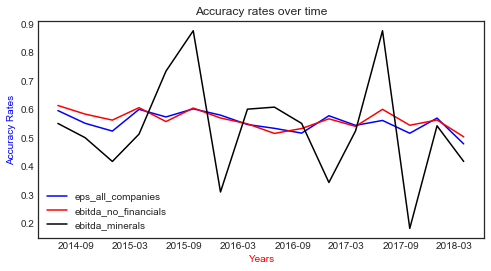

In [43]:
plt.rcParams["figure.figsize"] = (8,4)
plt.title('Accuracy rates over time')

experiment_results['eps_all_companies'][['equal_acc']].index = experiment_results['eps_all_companies'][['equal_acc']].index.to_datetime().strftime('%Y-%m')
x_values = experiment_results['eps_all_companies'][['equal_acc']].index.to_datetime()
plt.plot(x_values, experiment_results['eps_all_companies'].equal_acc, 'b-', label='eps_all_companies')
plt.plot(x_values, experiment_results['ebitda_no_financials'].equal_acc, 'r-', label='ebitda_no_financials')
plt.plot(x_values, experiment_results['ebitda_minerals'].equal_acc, 'k-', label='ebitda_minerals')
plt.xlabel('Years',color='r')
plt.ylabel('Accuracy Rates', color='b')
plt.legend();

# Quality Check

### How Many companies out of the 1566 non financials have EBITDA estimates? 

In [40]:
cid = info[(info.economic_sector != 'Financials')]['df_company_id'].unique()
non_financials = df[df.index.get_level_values(0).isin(cid)]

In [41]:
print('There are {} companies with EBITDA consensus out of 1566 Non Financials'.format(len(non_financials[['consensus_ebt']].dropna().index.get_level_values(0).unique())))

There are 1559 companies with EBITDA consensus out of 1566 Non Financials


# The 7 missig companies

In [42]:
a = list(non_financials[['consensus_ebt']].index.get_level_values(0).unique())
b = list(non_financials[['consensus_ebt']].dropna().index.get_level_values(0).unique())

In [43]:
m = [x for x in a if x not in b]

In [44]:
filtered_non_financials = non_financials[~non_financials.index.get_level_values(0).isin(m)]

In [45]:
run(filtered_non_financials, feature_list=features_ebitda, experiment_name='filtered_non_financials_ebitda')

In [ ]:
len(filtered_non_financials.index.get_level_values(0).unique())

In [ ]:
#data[['df_company_id','consensus_ebt_surprise_true','consensus_ebt_surprise_pred','co_log_returns_true','co_log_returns_pred']]

# Using Actual EBITDA Surp and EPS Actual Surp

In [44]:
features_ebitda_actual = ['consensus_ebt_surprise_true',
                         'normalised_smart_sal_surprise_pred',
                         'consensus_sal_surprise_smart']

run(non_financials, feature_list=features_ebitda_actual, experiment_name='ebitda_actual_non_financials')

Experiment Name: ebitda_actual_non_financials
Running an experiment on 1566 companies for:
['consensus_ebt_surprise_true', 'normalised_smart_sal_surprise_pred', 'consensus_sal_surprise_smart']


In [45]:
features_eps_actuals = ['consensus_eps_surprise_true',
                         'normalised_smart_sal_surprise_pred',
                         'consensus_eps_surprise_smart',
                         'consensus_sal_surprise_smart']

run(non_financials, feature_list=features_eps_actuals, experiment_name='eps_actuals_non_financials')

Experiment Name: eps_actuals_non_financials
Running an experiment on 1566 companies for:
['consensus_eps_surprise_true', 'normalised_smart_sal_surprise_pred', 'consensus_eps_surprise_smart', 'consensus_sal_surprise_smart']


In [46]:
start = '2014Q1'
stop = '2015Q4'

output_comparison = list()
for output in experiment_results.values():
    mtc = compute_metrics(output=output, start=start, stop=stop)
    output_comparison.append(mtc)

output_comparison = pd.DataFrame(output_comparison)
output_comparison.index = experiment_results.keys()
output_comparison = output_comparison.sort_values('equal_returns_low_ci', ascending=False)

In [47]:
output_comparison

mcc_low_ci  equal_acc_low_ci  \
eps_actuals_non_financials          0.395650          0.697298   
ebitda_actual_non_financials        0.267095          0.634267   
ebitda_no_financials                0.081096          0.540083   
ebitda_All                          0.056395          0.527591   
eps_no_financials                   0.059445          0.529488   
eps_all_companies                   0.024290          0.511916   
ebitda_consumer_cyclicals          -0.115969          0.442209   
eps_industrials                    -0.052231          0.474990   
ebitda_energy_basicMaterials       -0.104925          0.445792   
ebitda_industrials                 -0.036828          0.482228   
ebitda_industrials_no_commercial   -0.167266          0.411995   
ebitda_basic_materials             -0.173340          0.415600   
fcf_consumer_non_cyclicals         -0.232778          0.366163   
eps_minerals                       -0.548355          0.195624   
dps_consumer_non_cyclicals         -0.280485          0.330172   
ebitda_minerals                    -0.483682          0.261682   

                                  equal_returns_low_ci  mean_support  \
eps_actuals_non_financials                    0.019591    296.000000   
ebitda_actual_non_financials                  0.012528    329.000000   
ebitda_no_financials                          0.002386    326.500000   
ebitda_All                                    0.002316    421.000000   
eps_no_financials                             0.001935    311.000000   
eps_all_companies                             0.000600    406.666667   
ebitda_consumer_cyclicals                    -0.004638     66.833333   
eps_industrials                              -0.005710     65.000000   
ebitda_energy_basicMaterials                 -0.005747     58.333333   
ebitda_industrials                           -0.006210     66.833333   
ebitda_industrials_no_commercial             -0.009803     68.500000   
ebitda_basic_materials                       -0.010066     26.166667   
fcf_consumer_non_cyclicals                   -0.013560     26.500000   
eps_minerals                                 -0.013668     12.333333   
dps_consumer_non_cyclicals                   -0.013944     27.833333   
ebitda_minerals                              -0.026104     11.500000   

                                  equal_acc_mean  mkt_direction_mean  
eps_actuals_non_financials              0.766561            0.477636  
ebitda_actual_non_financials            0.699238            0.512698  
ebitda_no_financials                    0.587159            0.535023  
ebitda_All                              0.572008            0.542083  
eps_no_financials                       0.593741            0.537193  
eps_all_companies                       0.573651            0.538187  
ebitda_consumer_cyclicals               0.558122            0.527396  
eps_industrials                         0.565906            0.530535  
ebitda_energy_basicMaterials            0.597755            0.488203  
ebitda_industrials                      0.575482            0.557819  
ebitda_industrials_no_commercial        0.521796            0.517181  
ebitda_basic_materials                  0.647628            0.459899  
fcf_consumer_non_cyclicals              0.576711            0.467520  
eps_minerals                            0.590675            0.356602  
dps_consumer_non_cyclicals              0.525326            0.467795  
ebitda_minerals                         0.597917            0.461510

In [57]:
"""
After using actuals eps and actual ebitda on non_financials we see that equal_acc_mean drops by 17% for eps 
and 11 % for ebitda, meaning its harder to predict eps compared to ebitda. 
"""

'\nAfter using actuals eps and actual ebitda on non_financials we see that equal_acc_mean drops by 17% for eps \nand 11 % for ebitda, meaning its harder to predict eps compared to ebitda. \n'